In [1]:
import os
n_jobs = 16
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time

import itertools
import collections.abc
import sys
from tqdm import tqdm
# !{sys.executable} -m pip install qiskit-machine-learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.optimize import minimize
# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import Session, Batch
from qiskit_machine_learning.optimizers import SPSA, Minimizer


from joblib import dump, load


In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)


def double_angle(quantumcircuit, num_wires,paramname='x'):
    #  creates a circuit that encodes features into wires via angle encoding with an RY then RZ gate
    #  the features are encoded 1-1 onto the qubits
    #  if more wires are passed then features the remaining wires will be filled from the beginning of the feature list
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_index = i % num_features
        quantumcircuit.ry(features[feature_index], i)
        quantumcircuit.rz(features[feature_index], i)

def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires,paramname='theta'):
    parameters = ParameterVector(paramname,num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
# def circuit(nqubits):
#     qc = QuantumCircuit(nqubits)
#     mitarai(qc,nqubits)
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     mitarai(qc,nqubits,paramname='x1')
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     HardwareEfficient(qc,nqubits)
#     qc.barrier()
#     return qc


def circuit(nqubits,RUD=1):
    qc = QuantumCircuit(nqubits)
    for i in range(RUD):
        double_angle(qc,nqubits,paramname=f'x{i}')
        qc.barrier()
        HardwareEfficient(qc,nqubits,paramname=f'theta{i}')
        qc.barrier()
    return qc

In [4]:
# with open('linear_train.bin','rb') as f:
#     train = joblib.load(f)

# with open('linear_test.bin','rb') as f:
#     test = joblib.load(f)

# with open('linear_scaler.bin','rb') as f:
#     scaler = joblib.load(f)
# X_train, y_train = train['X'],train['y']
# X_test, y_test = test['X'],test['y']


# with open('PCA5_0.8_Morgan_train.bin','rb') as f:
#     bse_train = joblib.load(f)

# with open('PCA5_0.8_Morgan_test.bin','rb') as f:
#     bse_test = joblib.load(f)

# with open('PCA5_0.8_Morgan_scaler.bin','rb') as f:
#     bse_scaler = joblib.load(f)

# X_bse_train, y_bse_train = bse_train['X'],bse_train['y']
# X_bse_test, y_bse_test = bse_test['X'],bse_test['y']


# X_bse_train[np.isclose(X_bse_train,1)]=1
# X_bse_train[np.isclose(X_bse_train,-1)]=-1



# X_train, y_train = X_bse_train, y_bse_train
# X_test, y_test = X_bse_test, y_bse_test
# scaler = bse_scaler



with open('0.1_5_DDCC_train.bin','rb') as f:
    ddcc_train = joblib.load(f)

with open('0.1_5_DDCC_test.bin','rb') as f:
    ddcc_test = joblib.load(f)

with open('0.1_5_DDCC_scaler.bin','rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(19,64,5)[0:1].reshape(-1,5)
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)[0:1].reshape(-1,5)
y_ddcc_train = y_ddcc_train.reshape(19,64)[0:1].flatten()
y_ddcc_test = y_ddcc_test.reshape(-1,64)[0:1].flatten()


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test
scaler = ddcc_scaler

print(X_train.shape, X_test.shape)

(64, 5) (64, 5)


In [5]:
num_qubits = 5
RUD = 3

In [6]:
# 
qc = circuit(num_qubits,RUD)

num_params = len([i for i in list(qc.parameters) if 'theta' in i.name]) // RUD
generator = np.random.default_rng(12958234)
load_params = None

if load_params!=None:
    print('Parameters loaded')
    x0 = np.load(load_params)['x0']
else:
    print('Parameters from scratch')
    x0 = np.tile(generator.uniform(-np.pi, np.pi, num_params),RUD)




Parameters from scratch


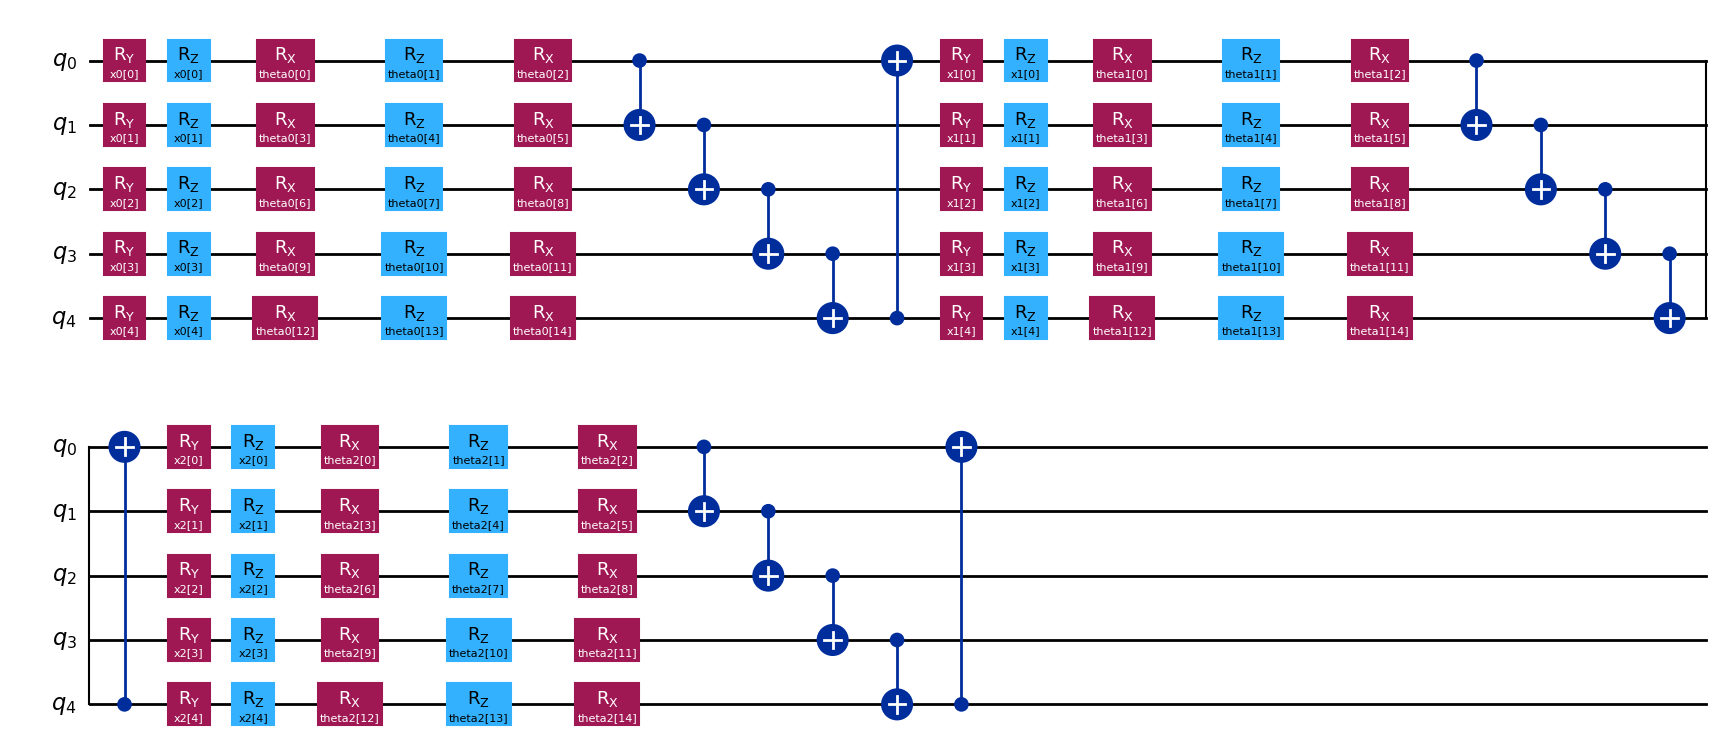

In [7]:
qc.draw('mpl', scale=1, plot_barriers=False)

In [8]:
# Select backend
# service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
# _backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
_backend = FakeQuebec()
target = _backend.target

# Generate pass manager
pm = generate_preset_pass_manager(target=target, optimization_level=0)
qc = pm.run(qc)


observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
observables = [SparsePauliOp(observables_labels)]

mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
print(mapped_observables)

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI'],
              coeffs=[1.+0.j])]


In [9]:
# Batches

In [10]:
def map2qiskit(params, ansatz, hamiltonian, estimator, num_qubits, X):
    if len(X)==1:
        featparams = dict([(i,X.item()) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    else:
        featparams = dict([(i,X[idx % num_qubits]) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    
    ansatz = ansatz.assign_parameters(featparams)    
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    y_pred = result[0].data.evs[0]
    return y_pred

In [11]:
def predict(params, ansatz, hamiltonian, estimator, num_qubits, X):
    # y_pred = np.array([map2qiskit(params, ansatz, hamiltonian, estimator, num_qubits, x) for x in tqdm(X)]).reshape(X.shape[0])
    y_pred = np.array(joblib.Parallel(n_jobs=n_jobs,verbose=0)(joblib.delayed(map2qiskit)(params, ansatz, hamiltonian, estimator, num_qubits, x) for x in tqdm(X))).reshape(X.shape[0])
    return y_pred

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator, num_qubits, X, y,n_jobs,cost_history_dict):
    """Return estimate of energy from estimator

    Parameters:

        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    t0=time.perf_counter()
    y_pred = predict(params, ansatz, hamiltonian, estimator, num_qubits, X)
    loss = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(loss)
    print(f"Iters. done: {cost_history_dict['iters']} Current cost: {loss} Accuracy: {r2} Time: {time.perf_counter()-t0}")
    with open('model_log.csv', 'a') as outfile:
        log = f"{time.asctime()},{cost_history_dict['iters']},{loss},{params}\n"
        outfile.write(log)
    return loss

In [13]:
def evaluate(params, ansatz, hamiltonian, estimator, num_qubits, n_jobs, X_train, y_train, X_test=None, y_test=None, plot: bool = False, title: str = 'defult',y_scaler=None):
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    
    y_train_pred = predict(params, ansatz, hamiltonian, estimator, num_qubits, X_train)
    y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    y_train = y_scaler.inverse_transform(y_train.reshape(-1, 1))

    scores['MSE_train'] = mean_squared_error(y_train, y_train_pred)
    scores['R2_train'] = r2_score(y_train, y_train_pred)
    scores['MAE_train'] = mean_absolute_error(y_train, y_train_pred)

    y_test_pred = None
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    if y_test is not None:
        y_test_pred = predict(params, ansatz, hamiltonian, estimator, num_qubits, X_test)
        y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
        scores['MSE_test'] = mean_squared_error(y_test, y_test_pred)
        scores['R2_test'] = r2_score(y_test, y_test_pred)
        scores['MAE_test'] = mean_absolute_error(y_test, y_test_pred)

    if plot:
        plt.figure()
        if y_test_pred is not None:
            plt.scatter(y_test, y_test_pred, color='b', s=10, label=f'Test, MAE = {scores["MAE_test"]:.2f}')
        plt.scatter(y_train, y_train_pred, color='r', s=10, label=f'Train, MAE = {scores["MAE_train"]:.2f}')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.axis('scaled')

        max_val = max(max(plt.xlim()), max(plt.ylim()))
        plt.xlim((0, max_val))
        plt.ylim((0, max_val))

        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        plt.plot([x_min, x_max], [y_min, y_max], 'k--', alpha=0.2, label='y=x')
        plt.legend()
        plt.savefig(title+'_plot.svg')

        if X_test.shape[1] == 1:
            plt.figure()
            plt.title(title)
            plt.scatter(X_train, y_train_pred, color='b', label='Train', s=10)
            plt.scatter(X_test, y_test_pred, color='orange', label='Test', s=10)
            plt.scatter(X_train, y_train, color='green', label='Data', s=10)
            plt.scatter(X_test, y_test, color='green', s=10)
            plt.legend()
            plt.savefig(title+'_1D_plot.svg')

    print(f'Scoring complete taking {time.time() - st} seconds. ')

    return scores, y_test_pred, y_train_pred

In [14]:
# estimator = StatevectorEstimator()
# estimator = Estimator(mode=_backend)
# estimator.options.default_shots = 1024.0
# estimator.options.resilience_level = 1

# cost_history_dict = {
#     "prev_vector": None,
#     "iters": 0,
#     "cost_history": [],
# }
# spsa = SPSA(maxiter=1)
# # Wrap the cost function so it can be called with just the required input
# result = spsa.minimize(
#     lambda params: cost_func(
#         params, qc, mapped_observables, estimator, num_qubits, X_train, y_train, n_jobs, cost_history_dict
#     ),
#     x0=x0,
# )

In [15]:
# # # Select backend
# # # service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
# # # _backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
# # _backend = FakeQuebec()
# # target = _backend.target

# # # Generate pass manager
# # pm = generate_preset_pass_manager(target=target, optimization_level=0)
# # qc = pm.run(qc)


# observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
# observables = [SparsePauliOp(observables_labels)]

# mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]


# scores = []
# with open('model_log.csv', 'w') as outfile:
#     outfile.write('Time,Iteration,Cost,Parameters')
#     outfile.write('\n')        

# spsa = SPSA(maxiter=1)

# # with Session(backend=_backend) as session:
# #     print(session.details())
# # estimator = Estimator(mode=session)
# # estimator.options.default_shots = 1024.0
# # estimator.options.resilience_level = 1
# estimator = StatevectorEstimator()
# cost_history_dict = {
#     "prev_vector": None,
#     "iters": 0,
#     "cost_history": [],
# }

# # for i in range(10):
# save_file = 'partial_state_model.bin'
# t0 = time.perf_counter()
# # res = spsa.minimize(
# #     lambda params: cost_func(
# #         params, qc, mapped_observables, estimator, num_qubits, X_train, y_train, n_jobs, cost_history_dict
# #     ),
# #     x0=x0,
# # )  
# res = minimize(cost_func,
#     x0,
#     args=(qc, mapped_observables, estimator, num_qubits, X_train, y_train,n_jobs,cost_history_dict),
#     method="cobyla", options={'maxiter':1000})      
# print(f"Step done in {time.perf_counter()-t0:.4f} seconds")
# x0 = res.x
# loss = res.fun
# progress = {'x': x0, 'loss': loss}
# dump(progress, save_file)
    
# progress = {'x': x0, 'loss': loss}
# dump(progress, 'final_state_model.bin')
# os.remove('partial_state_model.bin') 
# scores, y_test_pred, y_train_pred = evaluate(x0,qc, mapped_observables, estimator, num_qubits, n_jobs, X_train, y_train, X_test=X_test, y_test=y_test, plot = True, title = 'A2_HWE-CNOT',y_scaler=scaler)

# name = 'A2_HWE-CNOT_predicted_values.csv'
# train_pred, y_train, test_pred, y_test = y_train_pred.tolist(), y_train.tolist(), y_test_pred.tolist(), y_test.tolist()
# df_train = pd.DataFrame({'Predicted': train_pred, 'Reference': y_train})
# df_train['Data'] = 'Train'
# df_test = pd.DataFrame({'Predicted': test_pred, 'Reference': y_test})
# df_test['Data'] = 'Test'
# df = pd.concat([df_train, df_test], ignore_index=True)
# df = df[['Data', 'Predicted', 'Reference']]

# df.to_csv(name, index=False)

# results_title = 'A2_HWE-CNOT_results.json'
# with open(results_title, 'w') as outfile:
#     json.dump(scores, outfile)



In [ ]:
# estimator = StatevectorEstimator()
# job = estimator.run([(qc, mapped_observables)])
# y_pred = job.result()[0].data.evs
scores = []
with open('model_log.csv', 'w') as outfile:
    outfile.write('Time,Iteration,Cost,Parameters')
    outfile.write('\n')        

spsa = SPSA(maxiter=1)

with Session(backend=_backend) as session:
    print(session.details())
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1024.0
    estimator.options.resilience_level = 1
    
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    
    
    save_file = 'partial_state_model.bin'
    
    res = minimize(cost_func,
        x0,
        args=(qc, mapped_observables, estimator, num_qubits, X_train, y_train,n_jobs,cost_history_dict),
        method="cobyla", options={'maxiter':1000})        
    x0 = res.x
    loss = res.fun
    progress = {'x': x0, 'loss': loss}
    dump(progress, save_file)
        
    progress = {'x': x0, 'loss': loss}
    dump(progress, 'final_state_model.bin')
    os.remove('partial_state_model.bin') 
    scores, y_test_pred, y_train_pred = evaluate(x0,qc, mapped_observables, estimator, num_qubits, n_jobs, X_train, y_train, X_test=X_test, y_test=y_test, plot = True, title = 'A2_HWE-CNOT',y_scaler=scaler)
    
    name = 'A2_HWE-CNOT_predicted_values.csv'
    train_pred, y_train, test_pred, y_test = y_train_pred.tolist(), y_train.tolist(), y_test_pred.tolist(), y_test.tolist()
    df_train = pd.DataFrame({'Predicted': train_pred, 'Reference': y_train})
    df_train['Data'] = 'Train'
    df_test = pd.DataFrame({'Predicted': test_pred, 'Reference': y_test})
    df_test['Data'] = 'Test'
    df = pd.concat([df_train, df_test], ignore_index=True)
    df = df[['Data', 'Predicted', 'Reference']]

    df.to_csv(name, index=False)

    results_title = 'A2_HWE-CNOT_results.json'
    with open(results_title, 'w') as outfile:
        json.dump(scores, outfile)
    


None


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.40it/s]


Iters. done: 1 Current cost: 0.1346745957953336 Accuracy: -0.436169819156466 Time: 33.394343765990925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.21it/s]


Iters. done: 2 Current cost: 0.12393534547992785 Accuracy: -0.32164645940722725 Time: 33.98431418300606


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:22<00:00,  2.89it/s]


Iters. done: 3 Current cost: 0.12126481957792545 Accuracy: -0.293167972584367 Time: 34.308604723002645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.29it/s]


Iters. done: 4 Current cost: 0.13658060739550432 Accuracy: -0.4564955258642647 Time: 32.867024317005416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.48it/s]


Iters. done: 5 Current cost: 0.12206344294856299 Accuracy: -0.3016844917913426 Time: 33.60904014499101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:20<00:00,  3.13it/s]


Iters. done: 6 Current cost: 0.1186246331393084 Accuracy: -0.2650130257831873 Time: 35.231632076000096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.38it/s]


Iters. done: 7 Current cost: 0.11798681332584489 Accuracy: -0.25821131562585076 Time: 33.12416597601259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:17<00:00,  3.57it/s]


Iters. done: 8 Current cost: 0.12447964677468479 Accuracy: -0.32745088812996626 Time: 31.637546355006634


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.24it/s]


Iters. done: 9 Current cost: 0.12959372871809688 Accuracy: -0.3819874553009812 Time: 32.252477927992004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.43it/s]


Iters. done: 10 Current cost: 0.12178075847558648 Accuracy: -0.2986699447193024 Time: 33.414353085987386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.24it/s]


Iters. done: 11 Current cost: 0.11634860966672537 Accuracy: -0.24074151266141763 Time: 33.67585098100244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.33it/s]


Iters. done: 12 Current cost: 0.11767807672579347 Accuracy: -0.2549189486843033 Time: 34.25993069600372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.38it/s]


Iters. done: 13 Current cost: 0.1130331137893349 Accuracy: -0.2053850663581953 Time: 32.95655852399068


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.26it/s]


Iters. done: 14 Current cost: 0.10866617215968519 Accuracy: -0.15881600310255362 Time: 33.47023186399019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:21<00:00,  3.04it/s]


Iters. done: 15 Current cost: 0.12275801158188009 Accuracy: -0.3090913713339305 Time: 35.1253725530114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.29it/s]


Iters. done: 16 Current cost: 0.1108731081525004 Accuracy: -0.1823507673761966 Time: 33.119137795001734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.49it/s]


Iters. done: 17 Current cost: 0.10608842413985903 Accuracy: -0.1313268995667185 Time: 33.36650560199632


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.28it/s]


Iters. done: 18 Current cost: 0.12065188592778334 Accuracy: -0.2866316484596798 Time: 32.71810217600432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.31it/s]


Iters. done: 19 Current cost: 0.1046283558763485 Accuracy: -0.11575673236793449 Time: 32.939557288002106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.40it/s]


Iters. done: 20 Current cost: 0.10544761986578291 Accuracy: -0.12449336312296944 Time: 33.03491707499779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.22it/s]


Iters. done: 21 Current cost: 0.11374389370917712 Accuracy: -0.2129648230518124 Time: 33.09907646800275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.41it/s]


Iters. done: 22 Current cost: 0.09077803278166086 Accuracy: 0.03194310587316462 Time: 32.65164326100785


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:20<00:00,  3.15it/s]


Iters. done: 23 Current cost: 0.10624897647389837 Accuracy: -0.13303902957298086 Time: 35.249268916013534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.25it/s]


Iters. done: 24 Current cost: 0.112856896158187 Accuracy: -0.20350588163175698 Time: 33.90887421800289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.49it/s]


Iters. done: 25 Current cost: 0.1020281135095703 Accuracy: -0.0880277491279624 Time: 32.89484496800287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.36it/s]


Iters. done: 26 Current cost: 0.09534744653726626 Accuracy: -0.0167851200278204 Time: 33.3754357680009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.46it/s]


Iters. done: 27 Current cost: 0.10232372651133531 Accuracy: -0.09118016602424417 Time: 32.58366615299019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.51it/s]


Iters. done: 28 Current cost: 0.09164917924078472 Accuracy: 0.022653200488484293 Time: 33.267762015995686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:20<00:00,  3.18it/s]


Iters. done: 29 Current cost: 0.09796455297651475 Accuracy: -0.04469394172779961 Time: 33.270588990009855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.22it/s]


Iters. done: 30 Current cost: 0.08831935183393172 Accuracy: 0.05816247821440279 Time: 32.69824083500134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.43it/s]


Iters. done: 31 Current cost: 0.1131291480019739 Accuracy: -0.2064091751515731 Time: 32.98385875701206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.46it/s]


Iters. done: 32 Current cost: 0.09525429690358249 Accuracy: -0.015791772382913294 Time: 32.29457060499408


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.36it/s]


Iters. done: 33 Current cost: 0.09542277866862836 Accuracy: -0.01758846183728391 Time: 32.760005456992076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:18<00:00,  3.52it/s]
